In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastai.vision.models.xresnet import *
from fastai.vision.models.unet import DynamicUnet
from bpho import *

/home/fredmonroe/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
datasetname = 'combo_001'
data_path = Path('.')
datasets = data_path/'datasets'
datasources = data_path/'data'
dataset = datasets/datasetname

hr_tifs = dataset/'hr'
lr_tifs = dataset/'lr'
lr_up_tifs = dataset/'lr_up'

mname = 'combo'
model_dir = 'models'

In [3]:
def get_src(x_data, y_data_):
    def map_to_hr(x):
        hr_name = x.relative_to(x_data)
        return y_data_/hr_name
    src = (ImageImageList
            .from_folder(x_data, convert_mode='L')
            .split_by_rand_pct()
            .label_from_func(map_to_hr, convert_mode='L'))
    return src


def get_data(bs, size, x_data, y_data, max_zoom=1.1):
    src = get_src(x_data, y_data)
    tfms = get_transforms(flip_vert=True, max_zoom=max_zoom)
    data = (src
            .transform(tfms, size=size)
            .transform_y(tfms, size=size)
            .databunch(bs=bs))
    data.c = 3
    return data


def get_model(in_c, out_c, arch):
    body = nn.Sequential(*list(arch(c_in=in_c).children())[:-2])
    model = DynamicUnet(
        body, n_classes=out_c,
        blur=True, blur_final=True,
        self_attention=True, norm_type=NormType.Weight, 
        last_cross=True, bottle=True
    )
    return model

def xres_unet_learner(bs, img_size, arch, in_c=1, out_c=1, fp16=True):
    data = get_data(bs, img_size, lr_up_tifs, hr_tifs)
    model = get_model(in_c, out_c, arch)
    loss = F.mse_loss
    learn = Learner(data, model, loss_func=loss, metrics=sr_metrics, model_dir=model_dir) 
    if fp16: learn = learn.to_fp16(loss_scale=64)
    return learn

def do_fit(learn, save_name, lrs=slice(1e-3), pct_start=0.9, cycle_len=10):
    learn.fit_one_cycle(cycle_len, lrs, pct_start=pct_start)
    learn.save(save_name)
    num_rows = min(learn.data.batch_size, 3)
    learn.show_results(rows=num_rows, imgsize=5)

In [4]:
bs = 100
img_size = 128
arch = xresnet34
learn = xres_unet_learner(bs, img_size, arch)

In [5]:
if False:
    learn.lr_find()
    learn.recorder.plot()

epoch,train_loss,valid_loss,ssim,psnr,time
0,0.005965,0.001064,0.454183,29.874193,01:45
1,0.001131,0.000737,0.787699,31.587996,01:40


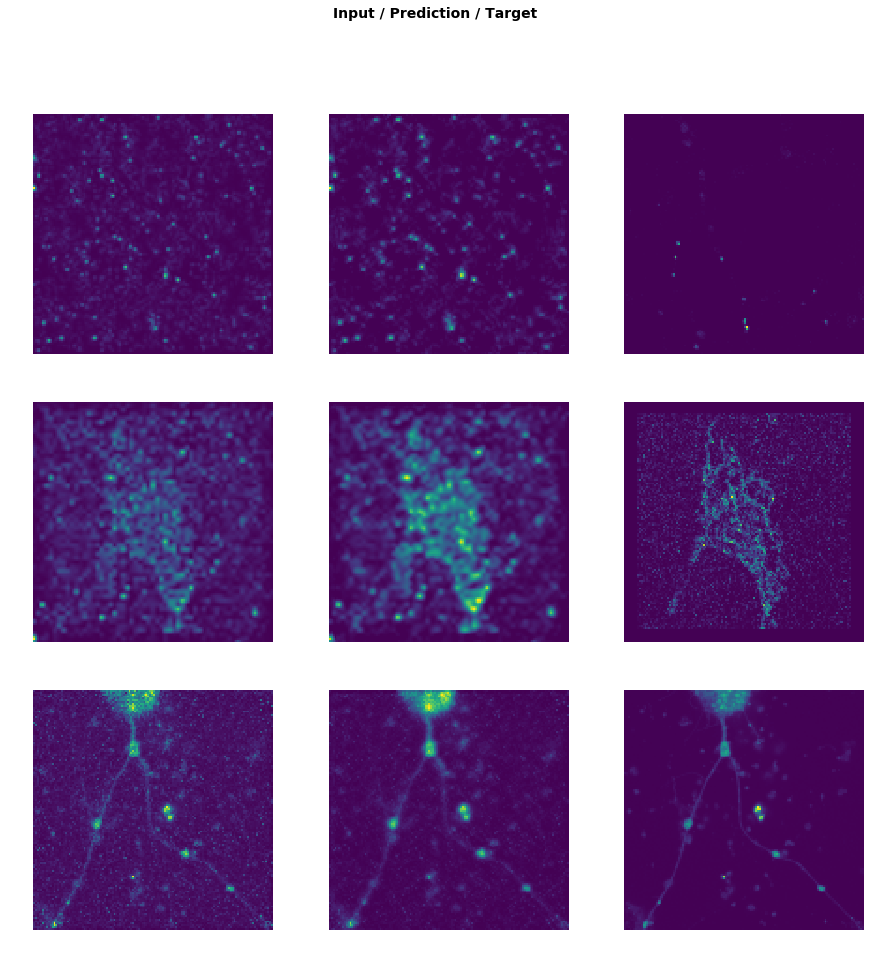

In [6]:
lr = 1e-3
do_fit(learn, f'{mname}.0', lrs=lr*10, cycle_len=2)

In [8]:
lr = 1e-3
bs = 40
img_size = 256
arch = xresnet34
learn = xres_unet_learner(bs, img_size, arch)
learn = learn.load(f'{mname}.0')

epoch,train_loss,valid_loss,ssim,psnr,time
0,0.001091,0.000861,0.768613,31.197924,06:08
1,0.000912,0.000834,0.814649,31.321285,05:38


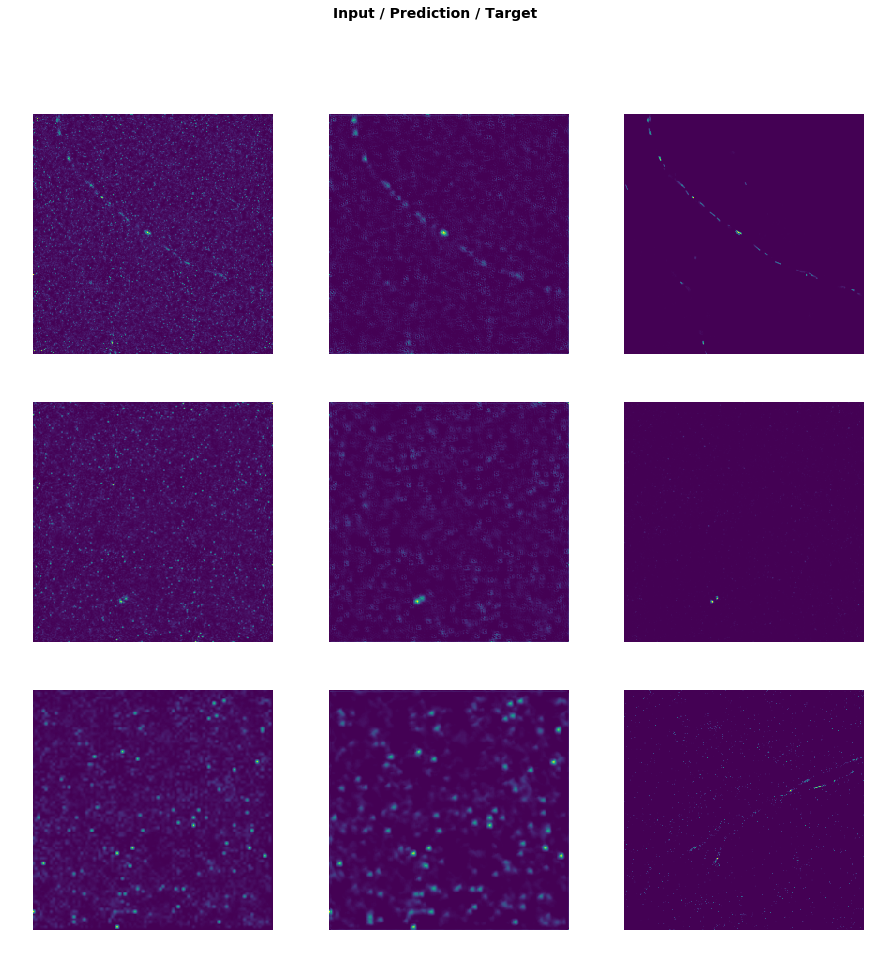

In [9]:
do_fit(learn, f'{mname}.1', lrs=lr, cycle_len=2)

epoch,train_loss,valid_loss,ssim,psnr,time
0,0.002808,0.003026,0.166835,25.773336,32:18
1,0.002815,0.002847,0.179223,26.113789,33:26


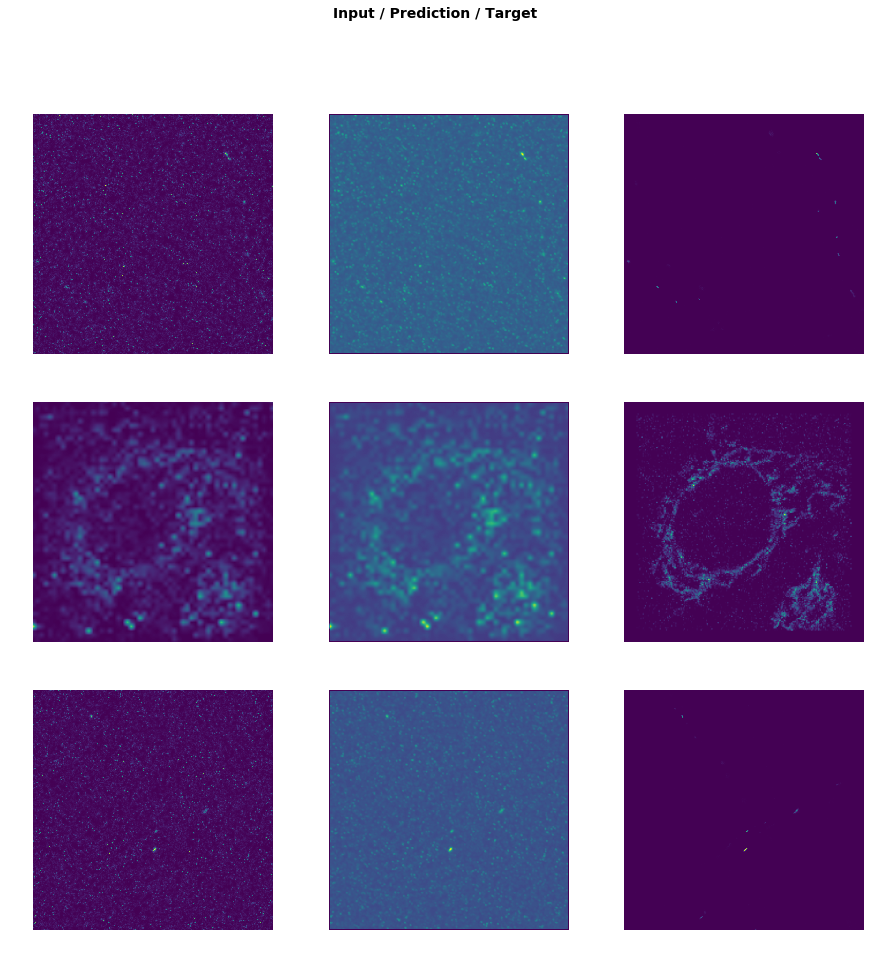

In [6]:
lr = 1e-3
bs = 10
img_size = 512
arch = xresnet34
learn = xres_unet_learner(bs, img_size, arch)
learn = learn.load(f'{mname}.1')

do_fit(learn, f'{mname}.2', lrs=lr/10, cycle_len=2)

NameError: name 'lr' is not defined